# All imports

In [2]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
sns.set_style('dark')

In [5]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
nltk.download('punkt')
nltk.download('wordnet')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
from gensim.models import Doc2Vec
from sklearn import utils

# Load data

In [7]:
if not os.path.exists('./data'):
  os.mkdir('./data')

gdd.download_file_from_google_drive(file_id='1e_-vl9IncR4T9P6KiCxVnmeOZJgxIAXr', dest_path='./data/train_csv.zip')
gdd.download_file_from_google_drive(file_id='12aofsxmKuzE5wLeFmTA0qX6x5jKLDzGY', dest_path='./data/glove.zip')
gdd.download_file_from_google_drive(file_id='18LzLy-AZDGafGy65YROc5r0XJaG23HBp', dest_path='./data/fasttext.zip')
gdd.download_file_from_google_drive(file_id='1AUQ-vzZM3B-ieKl9qCagSWlo-888gmbK', dest_path='./data/word2vec.gz')

In [7]:
! unzip ./data/fasttext.zip

Archive:  ./data/fasttext.zip
  inflating: wiki-news-300d-1M.vec   


In [8]:
! gunzip ./data/word2vec.gz

In [8]:
! unzip ./data/train_csv.zip 

Archive:  ./data/train_csv.zip
  inflating: train.csv               


In [10]:
! unzip ./data/glove.zip -d ./glove

Archive:  ./data/glove.zip
  inflating: ./glove/glove.twitter.27B.25d.txt  
  inflating: ./glove/glove.twitter.27B.50d.txt  
  inflating: ./glove/glove.twitter.27B.100d.txt  
  inflating: ./glove/glove.twitter.27B.200d.txt  


In [9]:
df = pd.read_csv('/content/train.csv')

# EDA

In [12]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [10]:
label_columns = df.select_dtypes(include=[int]).columns

Labels are binary

In [11]:
df.loc[:,label_columns].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Add clean label

In [12]:
df['clean'] = df.loc[:,label_columns].apply(lambda x: 1 if x.sum() == 0 else 0, axis=1)
# add clean column to label columns
label_columns = df.select_dtypes(include=[int]).columns

In [22]:
count_per_label = [df[column].sum() for column in label_columns]

Task seems to be inbalanced

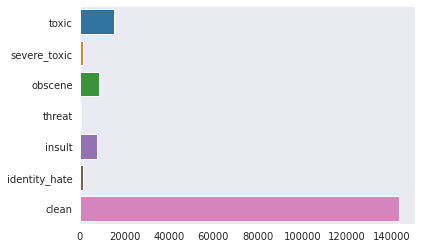

In [18]:
sns.barplot(x=count_per_label, y=label_columns)

Compare total number of bad comments to clean comments

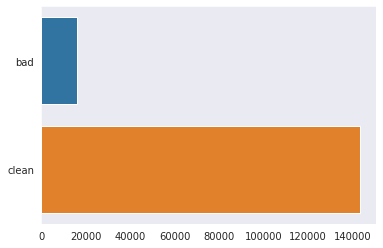

In [ ]:
sns.barplot(x=[df.shape[0] - df['clean'].sum(), df['clean'].sum()], y=['bad','clean'])

In [ ]:
concat_df = pd.concat([df['comment_text'].apply(lambda x: len(x)), df['clean']], axis=1)

In [ ]:
concat_df.rename(columns={'comment_text':'comment_text_length'}, inplace=True)

We can observe a difference in comment length distribution for clean and bad comments. Bad comments are shorter than clean.

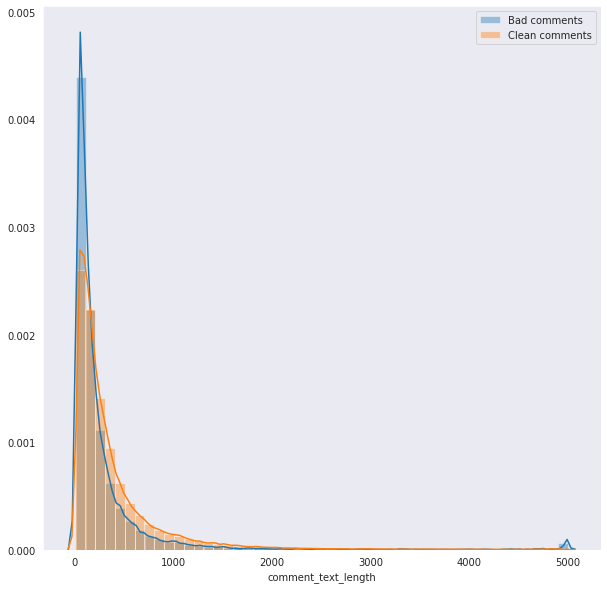

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sns.distplot(concat_df.query('clean == 0')['comment_text_length'], ax=ax, label='Bad comments')
sns.distplot(concat_df.query('clean == 1')['comment_text_length'], ax=ax, label='Clean comments')
ax.legend()

In [13]:
def tokenize(text):
    min_length = 3
    words = map(lambda word: word.lower(), word_tokenize(text))
    words = [word for word in words
                  if word not in cachedStopWords]
    tokens = (list(map(lambda token: PorterStemmer().stem(token),
                  words)));
    p = re.compile('[a-zA-Z]+');
    filtered_tokens = list(filter(lambda token:
                  p.match(token) and len(token)>=min_length,
         tokens))
    return filtered_tokens

In [ ]:
def visualize_most_popular(vectorised_data, vectorizer, words_num=20):
  feature_table = {val:key for (key, val) in vectorizer.vocabulary_.items()}
  sumed_data = vectorised_data.sum(axis=0)
  score_table = {feature:score for feature, score in enumerate(list(np.array(sumed_data).flatten()))}
  top_features = sorted(score_table.items(), reverse=True, key= lambda x: x[1])[:words_num]
  top_words = [feature_table[f[0]] for f in top_features]
  top_score = [f[1] for f in top_features]
  freq = {word:val for word, val in zip(top_words, top_score)}
  # Create and generate a word cloud image:
  wordcloud = WordCloud().fit_words(freq)

  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
def visualize_group(group_name):
  vectorizer = CountVectorizer(tokenizer=tokenize)
  vectorised_data = vectorizer.fit_transform(df[df[group_name] == 1]['comment_text'].values)
  visualize_most_popular(vectorised_data, vectorizer) 

Let's visualize the most popular words in different toxicity groups


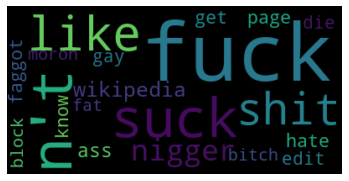

In [ ]:
visualize_group('toxic')

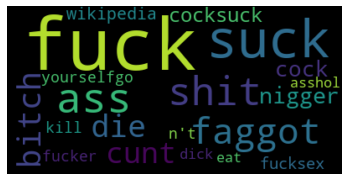

In [ ]:
visualize_group('severe_toxic')

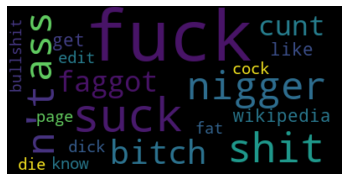

In [ ]:
visualize_group('obscene')

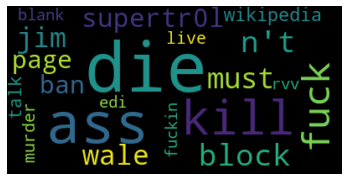

In [ ]:
visualize_group('threat')

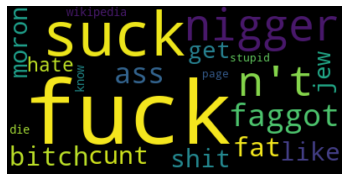

In [ ]:
visualize_group('insult')

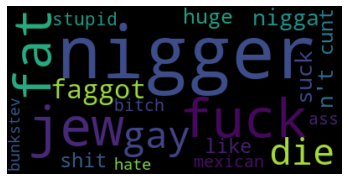

In [ ]:
visualize_group('identity_hate')

Clean group

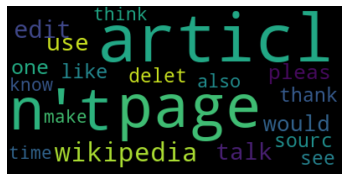

In [ ]:
vectorizer = CountVectorizer(tokenizer=tokenize)
vectorised_data = vectorizer.fit_transform(df[df['clean'] == 1]['comment_text'].values[:20000])
visualize_most_popular(vectorised_data, vectorizer)

We have to reduce data size due to significant computational time 

In [ ]:
df.shape

(159571, 9)

Use the rarest groups for stratification

In [14]:
_, reduced_df = train_test_split(df,stratify=df.loc[:,['severe_toxic','identity_hate','threat']],test_size=0.1)
reduced_df.shape

(15958, 9)

It seems that balance has been saved

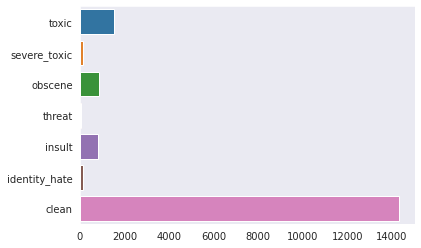

In [ ]:
count_per_label = [reduced_df[column].sum() for column in label_columns]
sns.barplot(x=count_per_label, y=label_columns)

Train/test split

In [15]:
train_df, test_df = train_test_split(reduced_df,test_size=0.3,stratify=reduced_df.loc[:,['severe_toxic','identity_hate','threat']])

In [ ]:
print(train_df.shape, test_df.shape)

(11170, 9) (4788, 9)


Balance has been saved

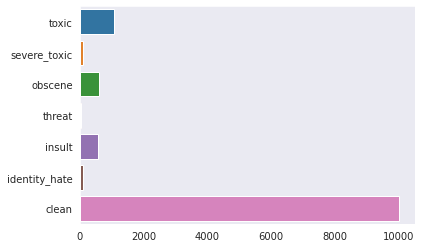

In [ ]:
count_per_label = [train_df[column].sum() for column in label_columns]
sns.barplot(x=count_per_label, y=label_columns)

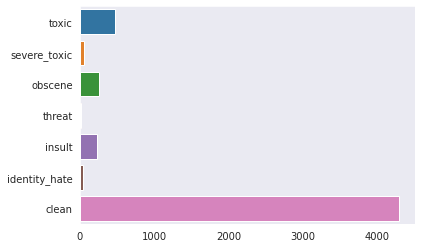

In [ ]:
count_per_label = [test_df[column].sum() for column in label_columns]
sns.barplot(x=count_per_label, y=label_columns)

# Classical approaches

In [ ]:
def tokenize(text):
    min_length = 3
    words = map(lambda word: word.lower(), word_tokenize(text))
    words = [word for word in words
                  if word not in cachedStopWords]
    tokens = (list(map(lambda token: PorterStemmer().stem(token),
                  words)));
    p = re.compile('[a-zA-Z]+');
    filtered_tokens = list(filter(lambda token:
                  p.match(token) and len(token)>=min_length,
         tokens))
    return filtered_tokens

In [ ]:
def fit_predict_classical(train_df, test_df, vectorizer):
  X_vec_train = vectorizer.fit_transform(train_df['comment_text'].values)
  clf = MultiOutputClassifier(LogisticRegression()).fit(X_vec_train, train_df.loc[:,['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']])
  prediction_train = clf.predict(X_vec_train)
  X_vec_test = vectorizer.transform(test_df['comment_text'].values)
  prediction_test = clf.predict(X_vec_test)
  return prediction_train, prediction_test

## Count vectors

In [ ]:
prediction_train, prediction_test = fit_predict_classical(train_df, test_df, CountVectorizer(tokenizer=tokenize))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
print(classification_report(train_df.loc[:,['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']], prediction_train,\
                            target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']))

               precision    recall  f1-score   support

        toxic       0.99      0.40      0.57      1051
 severe_toxic       0.64      0.14      0.24       111
      obscene       0.98      0.45      0.62       591
       threat       0.00      0.00      0.00        34
       insult       0.89      0.31      0.46       564
identity_hate       1.00      0.01      0.02        98
        clean       0.94      1.00      0.97     10031

    micro avg       0.94      0.87      0.90     12480
    macro avg       0.78      0.33      0.41     12480
 weighted avg       0.94      0.87      0.88     12480
  samples avg       0.93      0.93      0.93     12480



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(test_df.loc[:,['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']], prediction_test,\
                            target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']))

               precision    recall  f1-score   support

        toxic       0.98      0.34      0.51       455
 severe_toxic       0.56      0.10      0.18        48
      obscene       1.00      0.38      0.55       259
       threat       0.00      0.00      0.00        14
       insult       0.89      0.32      0.47       236
identity_hate       0.50      0.02      0.04        43
        clean       0.93      1.00      0.96      4312

    micro avg       0.93      0.87      0.90      5367
    macro avg       0.69      0.31      0.39      5367
 weighted avg       0.93      0.87      0.87      5367
  samples avg       0.93      0.92      0.93      5367



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TFIDF

In [ ]:
prediction_train, prediction_test = fit_predict_classical(train_df, test_df, TfidfVectorizer(tokenizer=tokenize))

In [ ]:
print(classification_report(train_df.loc[:,['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']], prediction_train,\
                            target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']))

               precision    recall  f1-score   support

        toxic       0.99      0.40      0.57      1051
 severe_toxic       0.64      0.14      0.24       111
      obscene       0.98      0.45      0.62       591
       threat       0.00      0.00      0.00        34
       insult       0.89      0.31      0.46       564
identity_hate       1.00      0.01      0.02        98
        clean       0.94      1.00      0.97     10031

    micro avg       0.94      0.87      0.90     12480
    macro avg       0.78      0.33      0.41     12480
 weighted avg       0.94      0.87      0.88     12480
  samples avg       0.93      0.93      0.93     12480



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(test_df.loc[:,['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']], prediction_test,\
                            target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']))

               precision    recall  f1-score   support

        toxic       0.98      0.34      0.51       455
 severe_toxic       0.56      0.10      0.18        48
      obscene       1.00      0.38      0.55       259
       threat       0.00      0.00      0.00        14
       insult       0.89      0.32      0.47       236
identity_hate       0.50      0.02      0.04        43
        clean       0.93      1.00      0.96      4312

    micro avg       0.93      0.87      0.90      5367
    macro avg       0.69      0.31      0.39      5367
 weighted avg       0.93      0.87      0.87      5367
  samples avg       0.93      0.92      0.93      5367



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Embeddings

In [21]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline
import gensim.models.keyedvectors as word2vec
import gc

Using TensorFlow backend.


In [22]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", 'clean']
y = train_df[list_classes].values
list_sentences_train = train_df["comment_text"]
list_sentences_test = test_df["comment_text"]

In [23]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [24]:
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [25]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="glove"):
            EMBEDDING_FILE='/content/glove/glove.twitter.27B.25d.txt'
            embed_size = 25
        elif(typeToLoad=="word2vec"):
            word2vecDict = word2vec.KeyedVectors.load_word2vec_format("/content/data/word2vec", binary=True)
            embed_size = 300
        elif(typeToLoad=="fasttext"):
            EMBEDDING_FILE='/content/wiki-news-300d-1M.vec'
            embed_size = 300

        if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
            embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
            f = open(EMBEDDING_FILE)
            for line in f:
                #split up line into an indexed array
                values = line.split()
                # we have some crashed embeddings
                if len(values) != embed_size+1:
                  continue
                #first index is word
                word = values[0]
                #store the rest of the values in the array as a new array
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs 
            f.close()
            print('Loaded %s word vectors.' % len(embeddings_index))
        else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [32]:
def create_network():
  inp = Input(shape=(maxlen, )) 
  x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
  x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
  x = GlobalMaxPool1D()(x)
  x = Dropout(0.1)(x)
  x = Dense(50, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(7, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
  return model

## Fasttext

In [28]:
embedding_matrix = loadEmbeddingMatrix('fasttext')

Loaded 999994 word vectors.
total embedded: 29294 common words


In [33]:
nn = create_network()

In [34]:
nn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 300)          12348600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 120)          173280    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 120)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0   

In [36]:
%%time
batch_size = 128
epochs = 10
hist = nn.fit(X_train,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 10053 samples, validate on 1117 samples
Epoch 1/10
10053/10053 [==============================] - 76s 8ms/step - loss: 0.2326 - accuracy: 0.9398 - val_loss: 0.1586 - val_accuracy: 0.9573
Epoch 2/10
10053/10053 [==============================] - 74s 7ms/step - loss: 0.1644 - accuracy: 0.9564 - val_loss: 0.1582 - val_accuracy: 0.9573
Epoch 3/10
10053/10053 [==============================] - 74s 7ms/step - loss: 0.1572 - accuracy: 0.9564 - val_loss: 0.1556 - val_accuracy: 0.9573
Epoch 4/10
10053/10053 [==============================] - 74s 7ms/step - loss: 0.1469 - accuracy: 0.9567 - val_loss: 0.1524 - val_accuracy: 0.9573
Epoch 5/10
10053/10053 [==============================] - 74s 7ms/step - loss: 0.1361 - accuracy: 0.9577 - val_loss: 0.1316 - val_accuracy: 0.9592
Epoch 6/10
10053/10053 [==============================] - 74s 7ms/step - loss: 0.1220 - accuracy: 0.9617 - val_loss: 0.1242 - val_accuracy: 0.9621
Epoch 7/10
10053/10053 [==============================] - 74s 7ms/ste

In [37]:
prediction_test = nn.predict(X_test)

In [38]:
prediction_test[prediction_test >= 0.5] = 1
prediction_test[prediction_test < 0.5] = 0

In [39]:
print(classification_report(test_df.loc[:,['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']], prediction_test,\
                            target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']))

               precision    recall  f1-score   support

        toxic       0.91      0.28      0.43       459
 severe_toxic       0.00      0.00      0.00        48
      obscene       0.86      0.31      0.46       254
       threat       0.00      0.00      0.00        14
       insult       0.80      0.29      0.43       231
identity_hate       0.00      0.00      0.00        43
        clean       0.93      1.00      0.96      4299

    micro avg       0.92      0.85      0.89      5348
    macro avg       0.50      0.27      0.33      5348
 weighted avg       0.90      0.85      0.85      5348
  samples avg       0.92      0.91      0.92      5348



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Glove

In [50]:
embedding_matrix = loadEmbeddingMatrix('glove')

Loaded 1193513 word vectors.
total embedded: 27121 common words


In [51]:
nn = create_network()

In [52]:
nn.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 25)           1029050   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200, 120)          41280     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 120)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0   

In [53]:
%%time
batch_size = 128
epochs = 10
hist = nn.fit(X_train,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 10053 samples, validate on 1117 samples
Epoch 1/10
10053/10053 [==============================] - 39s 4ms/step - loss: 0.2427 - accuracy: 0.9259 - val_loss: 0.1576 - val_accuracy: 0.9573
Epoch 2/10
10053/10053 [==============================] - 38s 4ms/step - loss: 0.1641 - accuracy: 0.9564 - val_loss: 0.1568 - val_accuracy: 0.9573
Epoch 3/10
10053/10053 [==============================] - 38s 4ms/step - loss: 0.1603 - accuracy: 0.9564 - val_loss: 0.1568 - val_accuracy: 0.9573
Epoch 4/10
10053/10053 [==============================] - 38s 4ms/step - loss: 0.1576 - accuracy: 0.9564 - val_loss: 0.1552 - val_accuracy: 0.9573
Epoch 5/10
10053/10053 [==============================] - 38s 4ms/step - loss: 0.1526 - accuracy: 0.9564 - val_loss: 0.1519 - val_accuracy: 0.9573
Epoch 6/10
10053/10053 [==============================] - 38s 4ms/step - loss: 0.1467 - accuracy: 0.9565 - val_loss: 0.1441 - val_accuracy: 0.9573
Epoch 7/10
10053/10053 [==============================] - 38s 4ms/ste

In [57]:
prediction_test = nn.predict(X_test)

In [58]:
prediction_test[prediction_test >= 0.5] = 1
prediction_test[prediction_test < 0.5] = 0

In [59]:
print(classification_report(test_df.loc[:,['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']], prediction_test,\
                            target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']))

               precision    recall  f1-score   support

        toxic       0.90      0.14      0.24       459
 severe_toxic       0.00      0.00      0.00        48
      obscene       0.80      0.19      0.31       254
       threat       0.00      0.00      0.00        14
       insult       0.81      0.15      0.26       231
identity_hate       0.00      0.00      0.00        43
        clean       0.91      1.00      0.95      4299

    micro avg       0.91      0.83      0.87      5348
    macro avg       0.49      0.21      0.25      5348
 weighted avg       0.88      0.83      0.81      5348
  samples avg       0.91      0.91      0.91      5348



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Word2vec

In [ ]:
embedding_matrix = loadEmbeddingMatrix('word2vec')

Unfortunately, there is not enough memory for preptrained google embeddings. Do I have to find another set?

# Doc2Vec

In [68]:
train_tagged = train_df.apply(
    lambda x: TaggedDocument(words=tokenize(x['comment_text']),tags=[x.name]), axis=1)
test_tagged = test_df.apply(
    lambda x: TaggedDocument(words=tokenize(x['comment_text']),tags=[x.name]), axis=1)

In [69]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [70]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 11170/11170 [00:00<00:00, 1245921.22it/s]


In [71]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 11170/11170 [00:00<00:00, 2288957.19it/s]


CPU times: user 49.5 s, sys: 2.76 s, total: 52.3 s
Wall time: 30.5 s


In [72]:
def vec_for_learning(model, tagged_docs,df):
    sents = tagged_docs.values
    targets, regressors = zip(*[(df.loc[doc.tags[0],label_columns].values, model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [73]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged, train_df)
y_test, X_test = vec_for_learning(model_dbow, test_tagged, test_df)
y_train=np.asarray(y_train,dtype=int)
y_test=np.asarray(y_test,dtype=int)

In [75]:
clf = MultiOutputClassifier(LogisticRegression()).fit(X_train, y_train)
prediction_train = clf.predict(X_train)
prediction_test = clf.predict(X_test)

In [76]:
print(classification_report(y_train, prediction_train,\
                            target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']))

               precision    recall  f1-score   support

        toxic       0.75      0.01      0.01      1086
 severe_toxic       1.00      0.01      0.02       111
      obscene       0.67      0.01      0.01       586
       threat       0.00      0.00      0.00        34
       insult       0.50      0.00      0.01       556
identity_hate       1.00      0.01      0.02        98
        clean       0.90      1.00      0.95     10039

    micro avg       0.90      0.80      0.85     12510
    macro avg       0.69      0.15      0.15     12510
 weighted avg       0.86      0.80      0.76     12510
  samples avg       0.90      0.90      0.90     12510



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
print(classification_report(y_test, prediction_test,\
                            target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']))

               precision    recall  f1-score   support

        toxic       0.83      0.01      0.02       457
 severe_toxic       0.00      0.00      0.00        48
      obscene       1.00      0.01      0.02       241
       threat       0.00      0.00      0.00        14
       insult       0.00      0.00      0.00       233
identity_hate       0.00      0.00      0.00        43
        clean       0.90      1.00      0.95      4296

    micro avg       0.90      0.81      0.85      5332
    macro avg       0.39      0.15      0.14      5332
 weighted avg       0.84      0.81      0.76      5332
  samples avg       0.90      0.90      0.90      5332



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BERT

Will be done later

# Points for the discussion



1.   Which f-score is more preferable and why?
2.   Discuss details of bidirectional LSTM layer
3.   How we can choose maxlen properly? We have encountered a plenty of hyperparams, how can they be chosen?
4.   Batch size influences on quality, doesn't it? What about calculation speed?

